In [ ]:
import pandas as pd
import numpy as np

def fix_nan(csv_data):
    """

    :param csv_data: pd.DataFrame from test.csv
    :return: DataFrame with fixed nan in some columns and make data as datetime
    """
    csv_data["period_start_dt"] = pd.to_datetime(csv_data["period_start_dt"], format='%Y.%m.%d')
    bad_column = ["PROMO1_FLAG","PROMO2_FLAG","NUM_CONSULTANT","AUTORIZATION_FLAG"]
    for replace_name in bad_column:
        csv_data[replace_name] = csv_data[replace_name].fillna(0.0)
    csv_data = csv_data.drop(columns=['PROMO2_FLAG', 'NUM_CONSULTANT'])
    return csv_data
    
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

def lagged_features(df
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , promo_filters = [0, 1]
                    , target_var = 'demand'):
    
    # loop by filter variables and window
    for w in windows:

        # check whether filtered df in not empty
        if len(df) > 0:
            
            # lagged features calculation
            lf_df = df.set_index(['product_rk', 'store_location_rk', 'period_start_dt']).\
                 demand.groupby(level=['product_rk','store_location_rk']).\
                apply(lambda x: x.rolling(window=w, min_periods=1).agg(aggregation_methods))

            # provide lags tranformations
            for l in lags:
                new_names = {x: "lag{0}_wdw{1}_{2}".
                              format(l, w, x) for x in lf_df.columns }

                df = df.merge(lf_df.shift(l).reset_index().rename(columns = new_names),
                    how='left', on =['product_rk', 'store_location_rk', 'period_start_dt'] )

    return df

def process(csv_data):
    """

    :param csv_data: pd.DataFrame from test.csv
    :return: fixed DataFrame with one-hot for product and store
    """
    csv_data = fix_nan(csv_data)
    
    def make_column_one_hot(data, column_name):
        data = pd.merge(data, pd.get_dummies(data[column_name], prefix=column_name), left_index=True, right_index=True)
        return data.drop(columns=column_name)

    def prepare_data(data):
        data = lagged_features(data)
        data = make_column_one_hot(data,"product_rk")
        data = make_column_one_hot(data,"store_location_rk")
        return data
        
    return prepare_data(csv_data)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

# for colab
from google.colab import drive
drive.mount('/content/drive')
PATH = 'drive/My Drive/Иннпрак'
train = pd.read_csv(PATH + '/train.csv')
raw_data = train
final = process(raw_data)
final

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,lag7_wdw7_median,lag7_wdw7_pctl90,lag7_wdw7_mean,lag7_wdw7_pctl10,lag14_wdw7_median,lag14_wdw7_pctl90,lag14_wdw7_mean,lag14_wdw7_pctl10,lag21_wdw7_median,lag21_wdw7_pctl90,lag21_wdw7_mean,lag21_wdw7_pctl10,lag28_wdw7_median,lag28_wdw7_pctl90,lag28_wdw7_mean,lag28_wdw7_pctl10,lag7_wdw14_median,lag7_wdw14_pctl90,lag7_wdw14_mean,lag7_wdw14_pctl10,lag14_wdw14_median,lag14_wdw14_pctl90,lag14_wdw14_mean,lag14_wdw14_pctl10,lag21_wdw14_median,lag21_wdw14_pctl90,lag21_wdw14_mean,lag21_wdw14_pctl10,lag28_wdw14_median,lag28_wdw14_pctl90,lag28_wdw14_mean,lag28_wdw14_pctl10,product_rk_40369,...,store_location_rk_317,store_location_rk_355,store_location_rk_380,store_location_rk_425,store_location_rk_453,store_location_rk_504,store_location_rk_517,store_location_rk_525,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380
0,0,2016-12-19,29.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2016-12-19,64.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2016-12-19,32.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,2016-12-19,10.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2016-12-19,15.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,35537,2019-12-30,NaN,0.0,1000.00,1000.0,1.0,1.0,NaN,1.333333,NaN,2.0,NaN,2.00,NaN,2.5,NaN,2.166667,NaN,5.0,6.8,4.428571,1.8,1.5,NaN,2.0,NaN,1.0,NaN,2.666667,NaN,1.0,NaN,1.923077,NaN,4.0,6.7,3.857143,0.3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
35340,35538,2019-12-30,NaN,0.0,2000.00,2000.0,1.0,20.0,NaN,20.666667,NaN,1.5,NaN,1.50,NaN,1.0,NaN,1.666667,NaN,1.0,4.0,1.857143,0.0,10.0,NaN,10.9,NaN,2.0,NaN,2.090909,NaN,2.0,NaN,4.230769,NaN,1.0,4.0,1.928571,0.0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
35341,35539,2019-12-30,NaN,0.0,3000.00,3000.0,1.0,9.0,NaN,9.000000,NaN,19.0,NaN,17.75,NaN,1.0,NaN,1.400000,NaN,0.0,3.8,1.428571,0.0,8.0,NaN,6.4,NaN,11.0,NaN,11.000000,NaN,2.5,NaN,2.250000,NaN,2.5,10.9,4.357143,0.0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0

In [60]:
raw_data[(raw_data["product_rk"] == 40369)].store_location_rk.unique()

array([ 309,  317,  355,  380,  425,  453,  504,  517,  525,  533,  535,
        540,  555,  557,  562,  637,  644,  657,  764,  798,  862,  866,
        874, 1005, 1034, 1079, 1080, 1143, 1162, 1173, 1185, 1191, 1202,
       1203, 1281, 1316, 1326, 1328, 1347, 1363, 1380])

In [64]:
y = final.demand
product = raw_data[(raw_data["product_rk"] == 40369) & (raw_data['store_location_rk'] == 425)]
product

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
2784,2802,40369,425,2016-12-19,105.000000,0.0,0.0,NaN,NaN,0.0,0.0
2789,2807,40369,425,2016-12-26,107.000000,1.0,0.0,500.0,500.0,0.0,1.0
2794,2812,40369,425,2017-01-02,48.808743,1.0,0.0,500.0,500.0,0.0,1.0
2799,2817,40369,425,2017-01-09,21.000000,0.0,0.0,500.0,500.0,0.0,1.0
2804,2822,40369,425,2017-01-16,21.000000,0.0,0.0,500.0,500.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3678,3696,40369,425,2019-12-02,NaN,0.0,0.0,500.0,500.0,0.0,1.0
3684,3702,40369,425,2019-12-09,NaN,0.0,0.0,500.0,500.0,0.0,1.0
3690,3708,40369,425,2019-12-16,NaN,0.0,0.0,500.0,500.0,0.0,1.0
3696,3714,40369,425,2019-12-23,NaN,0.0,0.0,500.0,500.0,0.0,1.0


In [65]:
product['demand']

2784    105.000000
2789    107.000000
2794     48.808743
2799     21.000000
2804     21.000000
           ...    
3678           NaN
3684           NaN
3690           NaN
3696           NaN
3702           NaN
Name: demand, Length: 159, dtype: float64

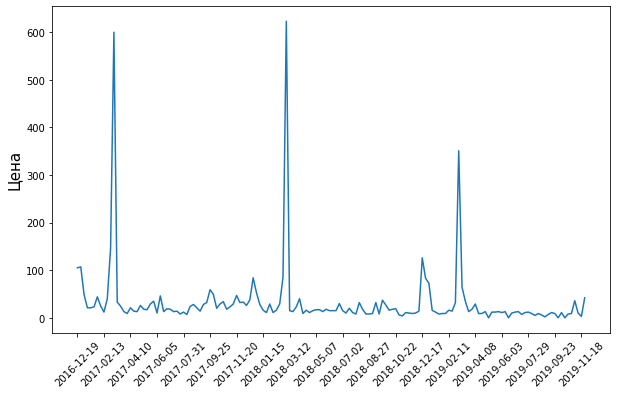

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(product['period_start_dt'], product['demand'])
plt.xticks(product['period_start_dt'][::8], rotation=45)

plt.ylabel("Цена", fontsize=15)

plt.show()

In [69]:
len(product['demand'])

159

In [81]:
demand = product['demand'].to_numpy()
demand = demand[~ np.isnan(demand)]
demand.argsort()[-5::], demand[demand.argsort()[-5::]]

(array([104,  10, 115,  11,  63]), array([126., 146., 351., 600., 623.]))

In [168]:
def fully_smooth_precision(X, m=52, known_to=80, pred_to=160):
    alpha = beta = gamma = 0.0005
    n = X.shape[0]
    l = np.zeros(pred_to+1)
    b = np.zeros(pred_to+1)
    s = np.zeros(pred_to+1)
    y_hat = np.zeros(pred_to+1)
    l[0] = sum(X[0:known_to:m]) / (known_to//m + 1)
    for i in range(m):
        s[i] = X[i]/l[0]
    b[0] = np.exp(1/m*(np.log(X[m:2*m].sum()) - np.log(X[0:m].sum())))
    for t in range(1, pred_to):
        if t < known_to:
            y_hat[t] = X[t]
        l[t] = alpha*y_hat[t]
        if (t >= m):
            l[t] /= s[t-m]
            s[t] = gamma*y_hat[t]/(l[t-1]*b[t-1]) + (1 - gamma)*s[t-m]
        l[t] += (1 - alpha)*l[t-1]*b[t-1]
        b[t] = beta*l[t]/l[t-1] + (1-beta)*b[t-1]
        #print(t,' ',l[t],' ',b[t],' ',s[t])
        y_hat[t+1] = l[t]*b[t]
        if (t - m + 1 >= 0):
            y_hat[t+1] *= s[t-m+1]
    return y_hat

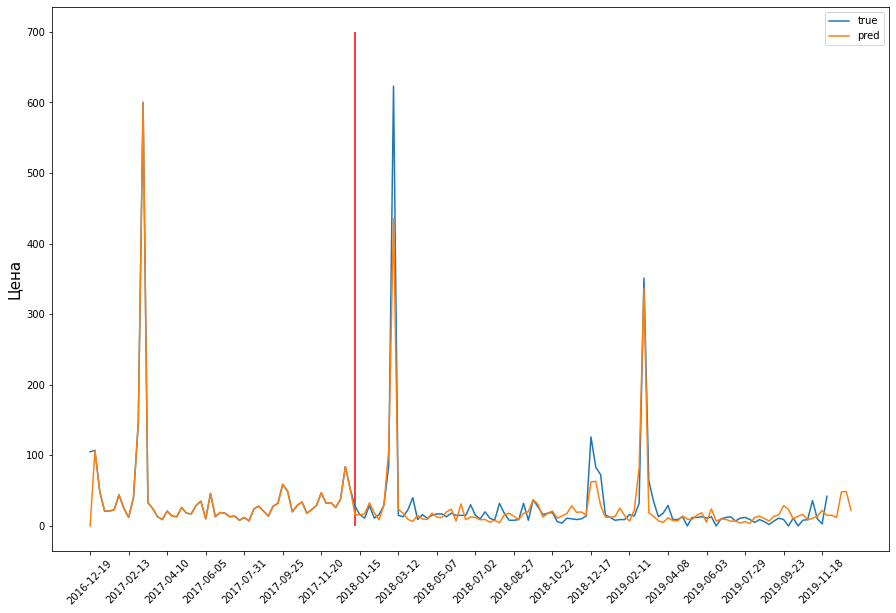

In [169]:
pred = fully_smooth_precision(demand, known_to=55)
plt.figure(figsize=(15, 10))
plt.plot(product['period_start_dt'], product['demand'], label='true')
plt.plot(product['period_start_dt'], pred[:-2], label='pred')
plt.vlines(product['period_start_dt'].to_numpy()[55],0,700,color='red')
plt.xticks(product['period_start_dt'][::8], rotation=45)
plt.legend()
plt.ylabel("Цена", fontsize=15)

plt.show()

(150, 2)


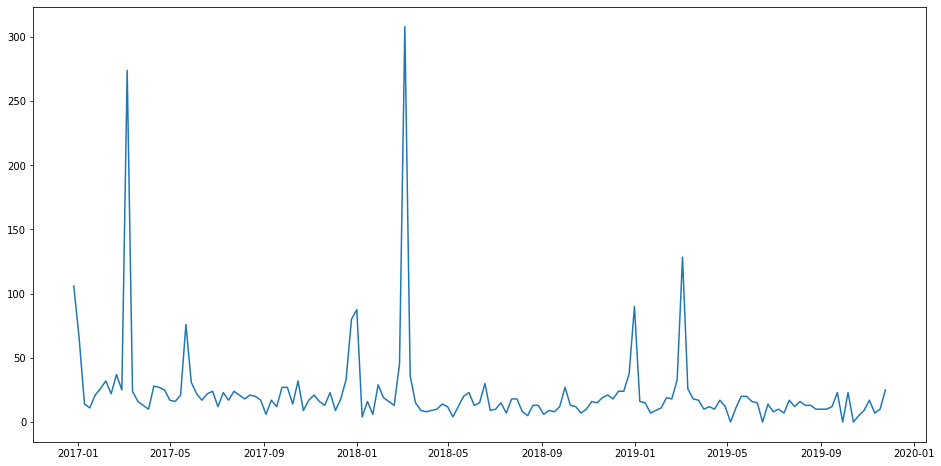

In [176]:
data = raw_data.copy()
data = data.dropna()
unique_items_grouped = data.groupby(["product_rk","store_location_rk"],as_index=False)
unique_items_sizes = unique_items_grouped.count()[["product_rk","store_location_rk","period_start_dt"]]
unique_items_sizes = pd.DataFrame(unique_items_sizes).rename(columns={"period_start_dt":"days in table"})

full_data_pairs = unique_items_sizes[unique_items_sizes["days in table"]==unique_items_sizes["days in table"].max()]
full_data_pairs = full_data_pairs.reset_index()[["product_rk","store_location_rk"]]
print(full_data_pairs.shape)
def get_local_data(number):
    if number<0 or number>=full_data_pairs.shape[0]:
        raise Exception("numer out of array")
    product_rk,store_location_rk = full_data_pairs.loc[number]
    return data[(data["product_rk"] == product_rk)&(data["store_location_rk"]==store_location_rk)]
local_data = get_local_data(42)
plt.figure(figsize=(16,8))
plt.plot(local_data["period_start_dt"],local_data["demand"])
plt.show()

In [180]:
demand = local_data['demand'].to_numpy()
demand = demand[~ np.isnan(demand)]
demand.argsort()[-5::], demand[demand.argsort()[-5::]]
len(demand)

153

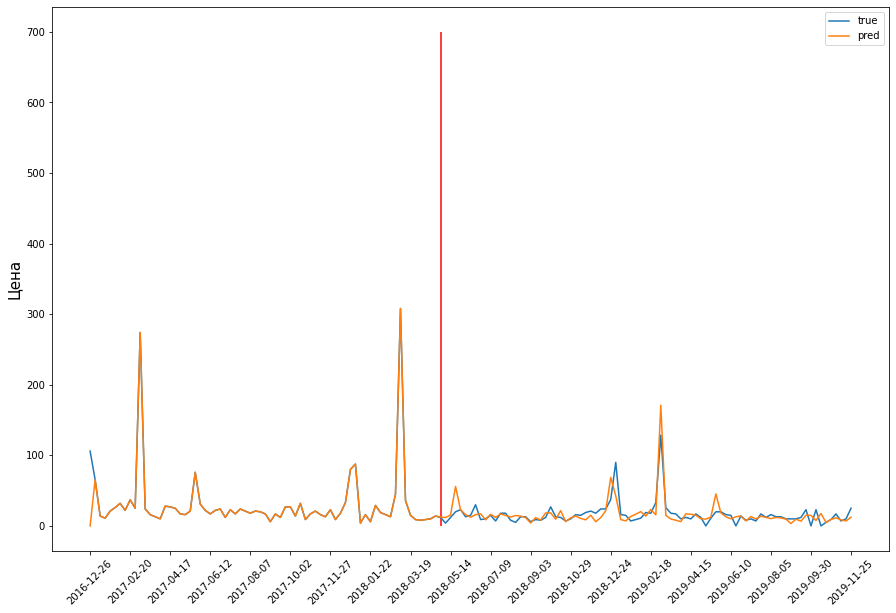

In [183]:
pred = fully_smooth_precision(demand, known_to=70)
plt.figure(figsize=(15, 10))
plt.plot(local_data['period_start_dt'], local_data['demand'], label='true')
plt.plot(local_data['period_start_dt'], pred[:153], label='pred')
plt.vlines(local_data['period_start_dt'].to_numpy()[70],0,700,color='red')
plt.xticks(local_data['period_start_dt'][::8], rotation=45)
plt.legend()
plt.ylabel("Цена", fontsize=15)

plt.show()

Вывод: статистические фичи содержат в себе полезную информацию о сезонности изменений: статистическое предсказание угадывает пики и чуть с меньшим успехом угадывает плато между ними.